# Refactor `merge_operator_data`

In [73]:
import altair as alt
import geopandas as gpd
import merge_data
import merge_operator_data
import viz_data_prep
import numpy as np
import pandas as pd
import yaml
from calitp_data_analysis.sql import to_snakecase
from merge_data import PORTFOLIO_ORGANIZATIONS_DICT, merge_in_standardized_route_names
from segment_speed_utils import gtfs_schedule_wrangling, helpers, time_series_utils
from segment_speed_utils.project_vars import COMPILED_CACHED_VIEWS, PROJECT_CRS
from shared_utils import (
    catalog_utils,
    dask_utils,
    gtfs_utils_v2,
    portfolio_utils,
    publish_utils,
    rt_dates,
)
from update_vars import GTFS_DATA_DICT, RT_SCHED_GCS, SCHED_GCS, SEGMENT_GCS

In [2]:
pd.options.display.max_columns = 100
pd.options.display.float_format = "{:.2f}".format
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)

In [3]:
analysis_date_list = rt_dates.y2024_dates

## Recreate old charts and maps `aggregate_filter_operator_dates.py`
* Use `operator_profiles_recent.parquet` and `operator_routes.parquet`
* Use <i>Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)</i>

In [4]:
OPERATOR_PROFILE = GTFS_DATA_DICT.digest_tables.operator_profiles

In [55]:
op_profile_ntd = pd.read_parquet(f"{RT_SCHED_GCS}{OPERATOR_PROFILE}_recent.parquet")

In [68]:
f"{RT_SCHED_GCS}{OPERATOR_PROFILE}_recent.parquet"

'gs://calitp-analytics-data/data-analyses/rt_vs_schedule/digest/operator_profiles_recent.parquet'

In [56]:
op_profile_ntd.service_date.unique()

array(['2024-03-13T00:00:00.000000000', '2024-06-12T00:00:00.000000000',
       '2024-12-11T00:00:00.000000000', '2025-03-12T00:00:00.000000000',
       '2025-04-16T00:00:00.000000000'], dtype='datetime64[ns]')

In [85]:
portfolio_name = "Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)"

In [80]:
ventura_op_profile = op_profile_ntd.loc[(
        op_profile_ntd.portfolio_organization_name
        == "Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)"
    )
]

In [90]:
ventura_op_profile

,service_date,portfolio_organization_name,caltrans_district,service_area_pop,service_area_sq_miles,hq_city,reporter_type,primary_uza_name
103,2025-04-16,"Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)",07 - Los Angeles / Ventura,8653897,2527,"Oxnard, Moorpark, Camarillo, Thousand Oaks, Simi Valley","Full Reporter, Reduced Reporter","Thousand Oaks, CA, Oxnard--San Buenaventura (Ventura), CA, Camarillo, CA, Simi Valley, CA"


In [78]:
# ventura_op_profile.columns = ventura_op_profile.columns.str.title().str.replace("_", " ")

In [81]:
ventura_op_profile.columns

Index(['service_date', 'portfolio_organization_name', 'caltrans_district',
       'service_area_pop', 'service_area_sq_miles', 'hq_city', 'reporter_type',
       'primary_uza_name'],
      dtype='object')

In [64]:
OPERATOR_ROUTE = GTFS_DATA_DICT.digest_tables.operator_routes_map

In [66]:
op_geography_df = gpd.read_parquet(f"{RT_SCHED_GCS}{OPERATOR_ROUTE}.parquet")

In [82]:
try:
    date = ventura_op_profile["service_date"].dt.to_pydatetime()[0]
except:
    pass

In [83]:
date

datetime.datetime(2025, 4, 16, 0, 0)

In [88]:
service_area = int(ventura_op_profile.service_area_sq_miles.values[0])
service_area = "{:,}".format(service_area)
service_pop = int(ventura_op_profile.service_area_pop.values[0])
service_pop = "{:,}".format(service_pop)

In [89]:
display(
        Markdown(
            f"""{portfolio_name} is headquartered in <b>{ventura_op_profile.hq_city.values[0]}</b> in the Urbanized Area of <b>{ventura_op_profile.primary_uza_name.values[0]}</b>.<br>
            This operator provides <b>{service_area}</b> square miles of public transit service, which has a service population of <b>{service_pop}</b>.<br>
            This organization is a {ventura_op_profile.organization_type.values[0]}.<br>
            <b>Data Source</b>: <a href="https://www.transit.dot.gov/ntd/data-product/2022-annual-database-agency-information">National Transit Database</a> Annual Agency Information.
            """
        )
    )

NameError: name 'Markdown' is not defined

In [71]:
ventura_geo = op_geography_df.loc[(
        op_geography_df.portfolio_organization_name
        == "Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)"
    )
]

In [7]:
schedule_df = merge_operator_data.concatenate_schedule_operator_metrics(
    analysis_date_list
)

In [8]:
schedule_df.head(2)

,schedule_gtfs_dataset_key,operator_n_routes,operator_n_trips,operator_n_shapes,operator_n_stops,operator_n_arrivals,operator_route_length_miles,operator_arrivals_per_stop,n_downtown_local_routes,n_local_routes,n_coverage_routes,n_rapid_routes,n_express_routes,n_rail_routes,n_ferry_routes,name,organization_source_record_id,organization_name,service_date
0,0139b1253130b33adcd4b3a4490530d2,30,421,204,513,7985,612.87,15.57,0,0,32,27,0,0,0,TCRTA TripShot Schedule,rec4YWVqVwJ9XqDbq,Tulare County Regional Transit Agency,2024-01-17
1,0139b1253130b33adcd4b3a4490530d2,30,421,204,474,7885,612.16,16.64,0,0,32,27,0,0,0,TCRTA TripShot Schedule,rec4YWVqVwJ9XqDbq,Tulare County Regional Transit Agency,2024-02-14


In [9]:
rt_schedule_df = merge_operator_data.concatenate_rt_vs_schedule_operator_metrics(
    analysis_date_list
)

In [10]:
rt_schedule_df.head(2)

,schedule_gtfs_dataset_key,vp_per_min_agency,spatial_accuracy_agency,service_date
0,0139b1253130b33adcd4b3a4490530d2,2.52,67.36,2024-01-17
1,0139b1253130b33adcd4b3a4490530d2,2.59,59.87,2024-02-14


In [11]:
gdf = (
    merge_operator_data.concatenate_operator_routes(analysis_date_list)
    .pipe(merge_data.merge_in_standardized_route_names)
    .pipe(
        portfolio_utils.standardize_portfolio_organization_names,
        PORTFOLIO_ORGANIZATIONS_DICT,
    )
)

In [12]:
gdf.columns

Index(['shape_array_key', 'geometry', 'feed_key', 'schedule_gtfs_dataset_key',
       'route_id', 'direction_id', 'route_key', 'route_length',
       'route_length_miles', 'is_downtown_local', 'is_local', 'is_coverage',
       'is_rapid', 'is_express', 'is_rail', 'is_ferry',
       'organization_source_record_id', 'organization_name', 'service_date',
       'portfolio_organization_name', 'name', 'combined_name',
       'recent_combined_name', 'recent_route_id'],
      dtype='object')

### Task #1: Aggregate `crosswalk` to `portfolio_organization_name`
* <i>Group by name-service_date-portfolio_organization_name to aggregate up to      portfolio_organization_name,because name indicates different feeds, so we want to sum those</i>. 
* AH: How do we account for situations when the different `organization_names` have different hq_cities, reporter_types, etc -> see Ventura County. we use these fields in this part of the portfolio. 
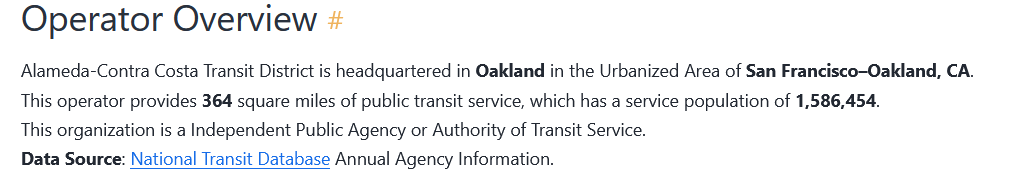

In [13]:
crosswalk_df = merge_operator_data.concatenate_crosswalks(analysis_date_list)

In [14]:
crosswalk_df.head(1)

,schedule_gtfs_dataset_key,name,caltrans_district,service_area_sq_miles,hq_city,service_area_pop,organization_type,primary_uza_name,reporter_type,service_date,portfolio_organization_name
0,0139b1253130b33adcd4b3a4490530d2,TCRTA TripShot Schedule,06 - Fresno / Bakersfield,4839,Visalia,473117,Independent Public Agency or Authority of Transit Service,"Tulare, CA",Full Reporter,2024-01-17,Tulare County Regional Transit Agency


In [15]:
crosswalk_df.portfolio_organization_name.nunique(), len(
    crosswalk_df
), crosswalk_df.name.nunique()

(181, 2243, 201)

In [16]:
crosswalk_df.loc[crosswalk_df.service_date == "2024-01-17"].shape

(177, 11)

In [17]:
crosswalk_df.loc[crosswalk_df.service_date == "2024-01-17"][
    "portfolio_organization_name"
].nunique()

157

In [18]:
crosswalk_df.loc[
    (crosswalk_df.service_date == "2024-01-17")
    & (
        crosswalk_df.portfolio_organization_name
        == "Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)"
    )
]

,schedule_gtfs_dataset_key,name,caltrans_district,service_area_sq_miles,hq_city,service_area_pop,organization_type,primary_uza_name,reporter_type,service_date,portfolio_organization_name
225,1770249a5a2e770ca90628434d4934b1,VCTC GMV Schedule,07 - Los Angeles / Ventura,28,Camarillo,209877,Independent Public Agency or Authority of Transit Service,"Oxnard--San Buenaventura (Ventura), CA",Full Reporter,2024-01-17,"Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)"
226,1770249a5a2e770ca90628434d4934b1,VCTC GMV Schedule,07 - Los Angeles / Ventura,50,Simi Valley,126356,"City, County or Local Government Unit or Department of Transportation","Simi Valley, CA",Reduced Reporter,2024-01-17,"Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)"
227,1770249a5a2e770ca90628434d4934b1,VCTC GMV Schedule,07 - Los Angeles / Ventura,167,Thousand Oaks,420862,"City, County or Local Government Unit or Department of Transportation","Thousand Oaks, CA",Reduced Reporter,2024-01-17,"Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)"
228,1770249a5a2e770ca90628434d4934b1,VCTC GMV Schedule,07 - Los Angeles / Ventura,20,Camarillo,68374,"City, County or Local Government Unit or Department of Transportation","Camarillo, CA",Reduced Reporter,2024-01-17,"Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)"
229,1770249a5a2e770ca90628434d4934b1,VCTC GMV Schedule,07 - Los Angeles / Ventura,84,Oxnard,374827,Independent Public Agency or Authority of Transit Service,"Oxnard--San Buenaventura (Ventura), CA",Full Reporter,2024-01-17,"Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)"
230,1770249a5a2e770ca90628434d4934b1,VCTC GMV Schedule,07 - Los Angeles / Ventura,12,Moorpark,35975,"City, County or Local Government Unit or Department of Transportation","Thousand Oaks, CA",Reduced Reporter,2024-01-17,"Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)"
231,1770249a5a2e770ca90628434d4934b1,VCTC GMV Schedule,07 - Los Angeles / Ventura,<NA>,Ojai,<NA>,"City, County or Local Government Unit or Department of Transportation",None,Rural Reporter,2024-01-17,"Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)"


In [19]:
operator_df = merge_operator_data.merge_data_sources_by_operator(
    schedule_df, rt_schedule_df, crosswalk_df
)

In [20]:
operator_df.head(1)

,schedule_gtfs_dataset_key,operator_n_routes,operator_n_trips,operator_n_shapes,operator_n_stops,operator_n_arrivals,operator_route_length_miles,operator_arrivals_per_stop,n_downtown_local_routes,n_local_routes,n_coverage_routes,n_rapid_routes,n_express_routes,n_rail_routes,n_ferry_routes,name,organization_source_record_id,organization_name,service_date,vp_per_min_agency,spatial_accuracy_agency,caltrans_district,service_area_sq_miles,hq_city,service_area_pop,organization_type,primary_uza_name,reporter_type,portfolio_organization_name
0,0139b1253130b33adcd4b3a4490530d2,30,421,204,513,7985,612.87,15.57,0,0,32,27,0,0,0,TCRTA TripShot Schedule,rec4YWVqVwJ9XqDbq,Tulare County Regional Transit Agency,2024-01-17,2.52,67.36,06 - Fresno / Bakersfield,4839,Visalia,473117,Independent Public Agency or Authority of Transit Service,"Tulare, CA",Full Reporter,Tulare County Regional Transit Agency


### Task #2: 
* Is there a short/long route, can it be flagged per date as a new column here?
* Piping the `portfolio_organization_name` goes at the end, 

In [21]:
FILE = GTFS_DATA_DICT.schedule_tables.operator_routes

concatenate_schedule_operator_metrics_df = (
    time_series_utils.concatenate_datasets_across_dates(
        SCHED_GCS,
        FILE,
        analysis_date_list,
        data_type="gdf",
    )
    .sort_values(["schedule_gtfs_dataset_key", "service_date"])
    .reset_index(drop=True)
    .pipe(
        portfolio_utils.standardize_portfolio_organization_names,
        PORTFOLIO_ORGANIZATIONS_DICT,
    )
)

In [22]:
concatenate_schedule_operator_metrics_df.columns

Index(['shape_array_key', 'geometry', 'feed_key', 'schedule_gtfs_dataset_key',
       'route_id', 'direction_id', 'route_key', 'route_length',
       'route_length_miles', 'is_downtown_local', 'is_local', 'is_coverage',
       'is_rapid', 'is_express', 'is_rail', 'is_ferry', 'name',
       'organization_source_record_id', 'organization_name', 'service_date',
       'portfolio_organization_name'],
      dtype='object')

In [23]:
concatenate_schedule_operator_metrics_df[["route_id", "route_key"]].sample(3)

,route_id,route_key
2198,6465,92e671b13c75d4a2a1f06a23b8c8c8b1
39625,480,d97dfb43de9a02e6330f9ffb97a90c51
32669,662,64f7a4c65c31381aebec93552c46e3f4


In [24]:
concatenate_schedule_operator_metrics_subset = concatenate_schedule_operator_metrics_df[
    [
        "portfolio_organization_name",
        "route_id",
        "route_length_miles",
        "service_date",
    ]
]

In [25]:
len(concatenate_schedule_operator_metrics_subset), len(concatenate_schedule_operator_metrics_df)

(40525, 40525)

In [26]:
concatenate_schedule_operator_metrics_subset = concatenate_schedule_operator_metrics_subset.drop_duplicates()

In [27]:
len(concatenate_schedule_operator_metrics_subset)

29113

In [28]:
def get_min_max(group):
    min_row = group.nsmallest(1, "route_length_miles").assign(
        long_short_route="shortest"
    )
    max_row = group.nlargest(1, "route_length_miles").assign(long_short_route="longest")
    return pd.concat([min_row, max_row])

In [29]:
longest_shortest_route = (
    concatenate_schedule_operator_metrics_subset.groupby(
        ["service_date", "portfolio_organization_name"]
    )
    .apply(get_min_max)
    .drop(columns=["route_length_miles"])
    .reset_index(drop=True)
)

In [30]:
len(longest_shortest_route)

3838

In [31]:
# longest_shortest_route.groupby(["service_date", "portfolio_organization_name"]).agg(
#    {"route_id": "nunique"}
# )

In [32]:
longest_shortest_route.loc[
    longest_shortest_route.service_date == "2024-01-17"
].portfolio_organization_name.value_counts().head()

Alameda-Contra Costa Transit District                  2
POINT                                                  2
Mountain Area Regional Transit Authority               2
Mountain View Transportation Management Association    2
Napa Valley Transportation Authority                   2
Name: portfolio_organization_name, dtype: int64

In [33]:
longest_shortest_route.sample()

,portfolio_organization_name,route_id,service_date,long_short_route
1022,City of Gardena,4SCH,2024-04-17,shortest


### Why are there extra rows popping up?

In [34]:
#  Merge back with a left join
m1 = pd.merge(
    concatenate_schedule_operator_metrics_df,
    longest_shortest_route,
    on=["portfolio_organization_name", "route_id", "service_date"],
    how="outer",
    indicator=True,
)

In [35]:
len(concatenate_schedule_operator_metrics_df)

40525

In [36]:
len(m1)

40797

In [37]:
m1._merge.value_counts()

left_only     36476
both           4321
right_only        0
Name: _merge, dtype: int64

In [38]:
len(m1) - len(concatenate_schedule_operator_metrics_df)

272

In [39]:
def find_percentiles(df:pd.DataFrame, col_of_interest: str)->pd.DataFrame:
    """
    Take a column you're interested in and categorize it by row
    for each percentile group it belongs to. 
    """
    # Get percentiles in objects for total vehicle.
    p25 = df[col_of_interest].quantile(0.25).astype(float)
    p50 = df[col_of_interest].quantile(0.50).astype(float)
    p75 = df[col_of_interest].quantile(0.75).astype(float)

    # Make a dataframe out of this 
    percentile_data = {
    f"{col_of_interest}_percentile": [
        "25th percentile",
        "50th percentile",
        "< 75th percentile",
        "> 75th percentile",
    ],
    "percentile_group": [
        f"25 percentile (<={p25.astype(int)} miles)",
        f"26-50th percentile ({p25.astype(int) + 0.1}-{p50.astype(int)} miles)",
        f"51-75th percentile ({p50.astype(int) + 0.1}-{p75.astype(int)} miles)",
        f"76th percentile (>={p75.astype(int) + 0.1} miles)",
    ],
}
    percentile_df = pd.DataFrame(data=percentile_data)
    
    def categorize_percentile(row):
        if (row[col_of_interest] > 0) and (row[col_of_interest] <= p25):
            return "25th percentile"
        elif (row[col_of_interest] > p25) and (row[col_of_interest] <= p50):
            return "50th percentile"
        elif (row[col_of_interest] > p50) and (row[col_of_interest] <= p75):
            return "< 75th percentile"
        elif row[col_of_interest] > p75:
            return "> 75th percentile"
        else:
            return "Zero"

    # Actually categorize each value for percentile
    df[f"{col_of_interest}_percentile"] = df.apply(
        lambda x: categorize_percentile(x), axis=1
    )

    # Delete out routes w/o service mile info
    df = df.loc[
    df[f"{col_of_interest}_percentile"] != "Zero"
    ]
    
    # Merge the dataframes
    df2 = pd.merge(df, percentile_df, on = f"{col_of_interest}_percentile")
    return df2

In [40]:
# Delete out nan route_length_miles
concatenate_schedule_operator_metrics_subset2 = (
    concatenate_schedule_operator_metrics_subset.loc[
        concatenate_schedule_operator_metrics_subset.route_length_miles.notna()
    ]
)

In [41]:
len(concatenate_schedule_operator_metrics_subset2)

29050

In [42]:
percentile_df = pd.DataFrame()
for operator in list(
    concatenate_schedule_operator_metrics_subset2.portfolio_organization_name.unique()
):
    one_operator = concatenate_schedule_operator_metrics_subset2.loc[
        concatenate_schedule_operator_metrics_subset2.portfolio_organization_name
        == operator
    ]
    df = find_percentiles(one_operator, "route_length_miles")
    percentile_df = pd.concat([percentile_df, df], axis=0)

/tmp/ipykernel_972/777939519.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{col_of_interest}_percentile"] = df.apply(
/tmp/ipykernel_972/777939519.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{col_of_interest}_percentile"] = df.apply(
/tmp/ipykernel_972/777939519.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

In [43]:
len(percentile_df)

29050

In [44]:
percentile_df.sample(10)

,portfolio_organization_name,route_id,route_length_miles,service_date,route_length_miles_percentile,percentile_group
1338,FlixBus and Greyhound,2605,357.02,2024-03-13,50th percentile,26-50th percentile (240.1-358 miles)
359,San Joaquin Regional Transit District,545,11.48,2024-12-11,< 75th percentile,51-75th percentile (8.1-12 miles)
464,Santa Clara Valley Transportation Authority,Express 102,31.89,2024-05-22,> 75th percentile,76th percentile (>=16.1 miles)
145,Redding Area Bus Authority,1889,4.59,2024-02-14,25th percentile,25 percentile (<=6 miles)
48,Western Contra Costa Transit Authority,12,4.42,2024-07-17,25th percentile,25 percentile (<=6 miles)
6,Glenn County,17909,46.18,2024-07-17,25th percentile,25 percentile (<=46 miles)
770,Alameda-Contra Costa Transit District,376,13.51,2024-02-14,< 75th percentile,51-75th percentile (10.1-13 miles)
1255,Los Angeles County Metropolitan Transportation Authority,204-13183,12.74,2024-12-11,25th percentile,25 percentile (<=12 miles)
1821,FlixBus and Greyhound,US0240,253.26,2024-12-11,50th percentile,26-50th percentile (240.1-358 miles)
353,City of Santa Clarita,792,38.30,2024-01-17,> 75th percentile,76th percentile (>=15.1 miles)


In [45]:
#  Merge back with a left join
m2 = pd.merge(
    m1,
    percentile_df.drop(columns=["route_length_miles", "route_length_miles_percentile"]),
    on=["portfolio_organization_name", "route_id", "service_date"],
    how="left",
)

In [46]:
m2.shape

(40825, 24)

In [47]:
m1.shape

(40797, 23)

In [48]:
concatenate_schedule_operator_metrics_df.shape

(40525, 21)

In [49]:
# percentile_df.groupby(["portfolio_organization_name", "percentile_group"]).agg({"route_id":"nunique"})

### Task #3: DONE.
* <i>take input produced in concatenate_operator_routes
    get counties for operator-date
    df should only be operator-date-counties_served
    use this to merge into crosswalk and replace NTD column</i>

In [50]:
def get_counties() -> gpd.GeoDataFrame:
    """
    Load a geodataframe of the California counties.
    """
    ca_gdf = "https://opendata.arcgis.com/datasets/8713ced9b78a4abb97dc130a691a8695_0.geojson"
    my_gdf = to_snakecase(gpd.read_file(f"{ca_gdf}"))[["county_name", "geometry"]]

    return my_gdf

In [51]:
def counties_served_by_operator(gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    """
    Join the geodataframe produced by concatenate_operator_routes
    to find which counties an operator serves.
    """
    # Subset
    gdf2 = gdf[["route_id", "service_date", "portfolio_organization_name", "geometry"]]

    # Grab counties
    ca_counties = get_counties()

    # Sjoin
    counties_served = gpd.sjoin(
        gdf2, ca_counties.to_crs(gdf.crs), how="inner", predicate="intersects"
    ).drop(columns="index_right")

    # Drop Duplicates
    counties_served2 = (
        counties_served[["service_date", "portfolio_organization_name", "county_name"]]
        .drop_duplicates()
        .sort_values(by=["county_name"])
        .reset_index(drop=True)
    )

    # Concatenate the counties using a groupby
    counties_served3 = counties_served2.groupby(
        [
            "service_date",
            "portfolio_organization_name",
        ],
        as_index=False,
    ).agg({"county_name": ",".join})

    return counties_served3

In [52]:
counties_served_df = counties_served_by_operator(gdf)

DriverError: Failed to open dataset (flags=68): /vsicurl/https://opendata.arcgis.com/datasets/8713ced9b78a4abb97dc130a691a8695_0.geojson

In [ ]:
counties_served_df.head(2)

In [ ]:
crosswalk_df.sample()

In [ ]:
crosswalk_df2 = pd.merge(
    crosswalk_df,
    counties_served_df,
    how="outer",
    on=["portfolio_organization_name", "service_date"],
    indicator=True,
)

In [ ]:
crosswalk_df2._merge.value_counts()